# Importing packages and data

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import random
from scipy import stats
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
census_starter = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv")
revealed_test = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv")
sample_submission = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv")
test = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv")
train = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv")

In [4]:
train = pd.concat([train, revealed_test]).sort_values(['cfips','row_id']).reset_index(drop=True)
train.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269


# Population adjustment

In the beginning of each year the forecasting dataset updates the population value, which is used as a denominator for calculating microbusiness density. This leads to big jumps of density at the same time each year. In order to avoid this issue, all the density values were adjusted to use the most recent data as a denominator.

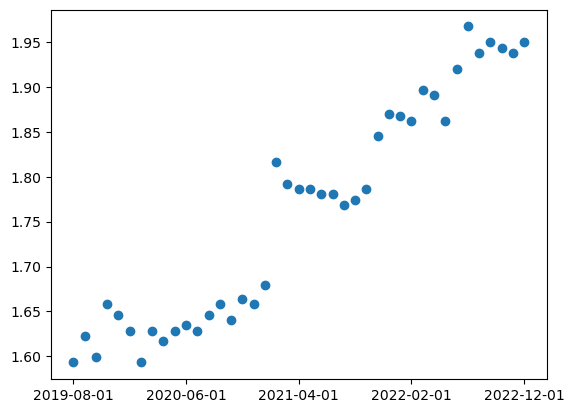

In [5]:
# an example of a county before the population adjustment
ax = plt.subplot()
ax.scatter(x=list(train[train.cfips == 19123].first_day_of_month), y=list(train[train.cfips == 19123].microbusiness_density))
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

In [6]:
# loading up the historical population data
col = "S0101_C01_026E"
pop2019 = pd.read_csv("/kaggle/input/census-data-for-godaddy/ACSST5Y2017.S0101-Data.csv")[["GEO_ID", "NAME", col]][1:]
pop2019["year"] = ["2019" for x in range(pop2019.shape[0])]
pop2020 = pd.read_csv("/kaggle/input/census-data-for-godaddy/ACSST5Y2018.S0101-Data.csv")[["GEO_ID", "NAME", col]][1:]
pop2020["year"] = ["2020" for x in range(pop2020.shape[0])]
pop2021 = pd.read_csv("/kaggle/input/census-data-for-godaddy/ACSST5Y2019.S0101-Data.csv")[["GEO_ID", "NAME", col]][1:]
pop2021["year"] = ["2021" for x in range(pop2021.shape[0])]
pop2022 = pd.read_csv("/kaggle/input/census-data-for-godaddy/ACSST5Y2020.S0101-Data.csv")[["GEO_ID", "NAME", col]][1:]
pop2022["year"] = ["2022" for x in range(pop2022.shape[0])]
pop2023 = pd.read_csv("/kaggle/input/census-data-for-godaddy/ACSST5Y2021.S0101-Data.csv")[["GEO_ID", "NAME", col]][1:]
pop2023["year"] = ["2023" for x in range(pop2023.shape[0])]

In [7]:
# adding a cfips column to the population data
pop2019["cfips"] = pop2019["GEO_ID"].map(lambda x: int(x.split("US")[-1]))
pop2020["cfips"] = pop2020["GEO_ID"].map(lambda x: int(x.split("US")[-1]))
pop2021["cfips"] = pop2021["GEO_ID"].map(lambda x: int(x.split("US")[-1]))
pop2022["cfips"] = pop2022["GEO_ID"].map(lambda x: int(x.split("US")[-1]))
pop2023["cfips"] = pop2023["GEO_ID"].map(lambda x: int(x.split("US")[-1]))
# putting the data in one df
pops = pd.concat([pop2019, pop2020, pop2021, pop2022, pop2023])

In [8]:
# creating a df with the most recent population and cfips
base = pop2023[[col, "cfips"]].copy()
base["base_pop"] = base[col]
base = base.drop(col, axis=1)

In [9]:
# finding multipliers that will adjust the historical data
mults = pops.merge(base, on="cfips")
mults["mult"] = mults.apply(lambda x: int(x[col])/int(x["base_pop"]), axis=1)
mults = mults[["NAME", "year", "cfips", "mult"]]

In [10]:
# adjusting the training dataset using the multipliers
train["year"] = train["first_day_of_month"].map(lambda x: x.split("-")[0])
train = train.merge(mults, on=["cfips", "year"], how="left")
train["microbusiness_density"] = train["microbusiness_density"]*train["mult"]
train = train.drop(["year", "NAME", "mult"], axis=1)
# saving the data as it's needed for target change later on
pop_adj = train
pop_adj = pop_adj[pop_adj.row_id.isin(revealed_test.row_id)]

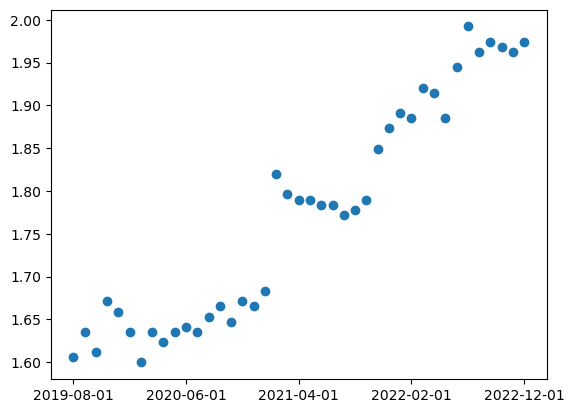

In [11]:
# an example of a county after the population adjustment
ax = plt.subplot()
ax.scatter(x=list(train[train.cfips == 19123].first_day_of_month), y=list(train[train.cfips == 19123].microbusiness_density))
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

# Smoothing

Another issue with the data can be observed between January and February 2021 - some changes occurred in the data gathering methodology which resulted in big differences between those two periods across many counties. We handled it by adjusting all the values before February 2021 through adding the difference between those two months.

Additionally, outliers were flagged by checking for a z-score of more than 2. They were then set to the average value of the adjacent points.

In [12]:
# finding the difference between jan and feb 2021 for each county
change = {}
 
for elem in list(set(train["cfips"])):
    val_feb = train[(train["cfips"]==elem) & (train["first_day_of_month"] == "2021-02-01")]["microbusiness_density"].values[0]
    val_jan = train[(train["cfips"]==elem) & (train["first_day_of_month"] == "2021-01-01")]["microbusiness_density"].values[0]
    change[elem] = val_feb-val_jan

In [13]:
# making a list of all the days across which the change has to be applied
days_to_change = list(set(train["first_day_of_month"]))
days_to_change.sort()
days_to_change = days_to_change[:days_to_change.index("2021-02-01")]

In [14]:
# applying the change to the specific days
for elem in list(set(train["cfips"])):
    for day in days_to_change:
        ind = train[(train["cfips"]==elem) & (train["first_day_of_month"] == day)].index.values[0]
        train.loc[ind,"microbusiness_density"] = train.loc[ind,"microbusiness_density"] + change[elem]

In [15]:
# creating a list of all the days to adjust outliers
all_days = list(set(train["first_day_of_month"]))
all_days.sort()

In [16]:
# smoothing out outliers
for elem in list(set(train["cfips"])):
    z_value_bool = list(abs(stats.zscore(train[train["cfips"] == elem]["microbusiness_density"]))>2)
    if z_value_bool[0] == True:
        ind = train[(train["cfips"]==elem) & (train["first_day_of_month"] == all_days[0])].index.values[0]
        train.loc[ind,"microbusiness_density"] = train[(train["cfips"]==elem) & (train["first_day_of_month"] == all_days[1])]["microbusiness_density"].values[0]
    if z_value_bool[-1] == True:
        ind = train[(train["cfips"]==elem) & (train["first_day_of_month"] == all_days[-1])].index.values[0]
        train.loc[ind,"microbusiness_density"] = train[(train["cfips"]==elem) & (train["first_day_of_month"] == all_days[-2])]["microbusiness_density"].values[0]
    for n in range(len(z_value_bool[1:-1])):
        if z_value_bool[1:-1][n] == True:
            ind = train[(train["cfips"]==elem) & (train["first_day_of_month"] == all_days[n+1])].index.values[0]
            val1 = train[(train["cfips"]==elem) & (train["first_day_of_month"] == all_days[n])]["microbusiness_density"].values[0]
            val2 = train[(train["cfips"]==elem) & (train["first_day_of_month"] == all_days[n+2])]["microbusiness_density"].values[0]
            train.loc[ind,"microbusiness_density"] = (val1+val2)/2

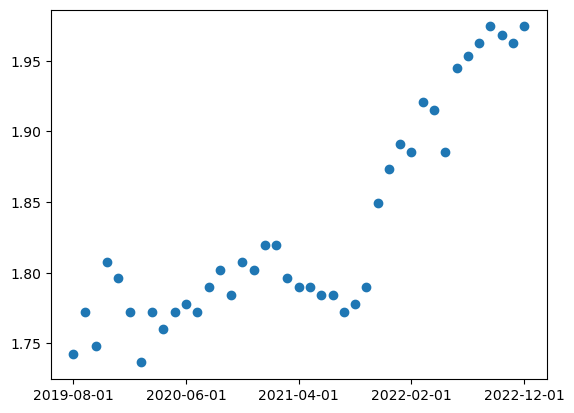

In [17]:
# an example of a county after smoothing
ax = plt.subplot()
ax.scatter(x=list(train[train.cfips == 19123].first_day_of_month), y=list(train[train.cfips == 19123].microbusiness_density))
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

# Target change

The function that was used to assess the outputs of this competition was SMAPE - as it is a relative metric, it performs better on percentage changes rather than raw numbers. Therefore, in this section we're changing the target values to percentage change.

In [18]:
# changing the target to percentage change (with removal of the oldest entry per county)
first_day = min(train.first_day_of_month)
train['density_change'] = train.groupby('cfips')['microbusiness_density'].shift(1)
train['density_change'] = train['microbusiness_density']/train['density_change'] - 1
train = train[train["first_day_of_month"] != first_day].reset_index(drop=True)
train["microbusiness_density"] = train['density_change']
train = train.drop("density_change", axis=1)
train["microbusiness_density"] = train["microbusiness_density"].map(lambda x: 0 if (x==np.inf or x== -1 or np.isnan(x)) else x)
# taking a look at the dataset
train.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,-0.038754,1198
1,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,0.056126,1269
2,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,-0.019461,1243


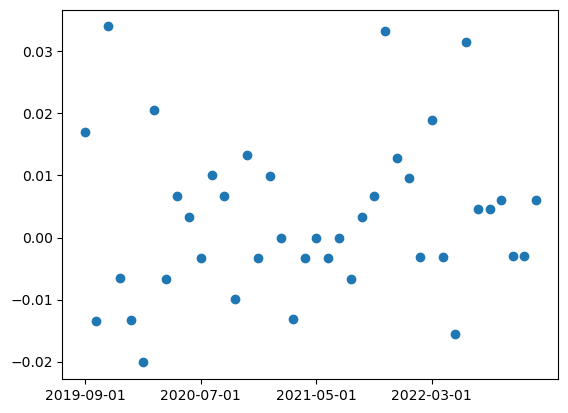

In [19]:
# an example of a county after smoothing
ax = plt.subplot()
ax.scatter(x=list(train[train.cfips == 19123].first_day_of_month), y=list(train[train.cfips == 19123].microbusiness_density))
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

# Feature engineering

The following step focuses on extracting as much information as possible from the available data. A census dataset is appended to the original data with information such as:
- median household income
- percentage of households with access to any broadband
- percentage of population with a college degree
- percentage of population born abroad
- percentage of workforce employed in IT

Additionally, a set of features based on the lagged density is created to aid in predicting the future data. The first recorded number of active microbusinesses is also added.

Lastly, in this step the data is split into train and test set and categorical variables are encoded, so that the dataset is ready for applying a model.

In [20]:
# preparing the train and test sets
train_days = set(train.first_day_of_month)
test = test[~test.first_day_of_month.isin(train_days)]
# adding a column to differentiate between test and train easily and putting the sets together for further modifications
train['istest'] = 0
test['istest'] = 1
data = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True).fillna(method='ffill')

In [21]:
# extracting year, month and day from the string
data["year"] = data["first_day_of_month"].map(lambda x: x.split("-")[0])
data["month"] = data["first_day_of_month"].map(lambda x: x.split("-")[1])
data["day"] = data["first_day_of_month"].map(lambda x: x.split("-")[2])

In [22]:
# adding a variable that indexes the data based on the date (for each county)
date_to_index = pd.DataFrame()
date_to_index["first_day_of_month"] = list(set(data.first_day_of_month))
date_to_index = date_to_index.sort_values("first_day_of_month").reset_index(drop=True)
date_to_index["t"] = date_to_index.index
date_to_index.tail()
data = data.merge(date_to_index, on="first_day_of_month", how="left")
# taking a look at the t value of a random county
data[data.cfips==1005].head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,day,t
92,1005_2019-09-01,1005,Barbour County,Alabama,2019-09-01,-0.074766,206.0,0,2019,09,01,0
93,1005_2019-10-01,1005,Barbour County,Alabama,2019-10-01,0.171717,240.0,0,2019,10,01,1
94,1005_2019-11-01,1005,Barbour County,Alabama,2019-11-01,-0.142241,207.0,0,2019,11,01,2


In [23]:
# only keeping census data for the cfips that exist in the training dataset
cfips_c = set(census_starter.cfips)
cfips_t = set(train.cfips)
cfips = [x for x in cfips_c if x in cfips_t]
census_cfips = census_starter[census_starter.cfips.isin(cfips)].sort_values("cfips").copy()

In [24]:
# creating a df containing metrics from the census data for each valid year
cats = ["median_hh_inc", "pct_bb", "pct_college", "pct_foreign_born", "pct_it_workers"]
cfips.sort()
df = pd.DataFrame()

for year in ["2019", "2020", "2021"]:
    t = pd.DataFrame()
    t["cfips"] = cfips
    t["year"] = [year for c in cfips]
    for cat in cats:
        t[cat] = census_cfips[cat+"_"+year]
    df = pd.concat([df, t])

# merging the census data with the density data - the below shows what was merged
data = data.merge(df, on=["cfips", "year"], how="left").fillna(method='ffill')
df.head(3)

,cfips,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers
0,1001,2019,58731.0,80.6,16.1,2.3,0.7
1,1003,2019,58320.0,81.8,21.0,3.7,1.4
2,1005,2019,32525.0,60.5,7.6,2.7,0.8


In [25]:
# appending a list of all the densities across time to each county
pdf = pd.DataFrame(data.groupby("cfips")["microbusiness_density"].agg(list))
pdf["density_list"] = pdf["microbusiness_density"]
pdf = pdf.drop("microbusiness_density", axis=1)
pdf = pdf.reset_index()
data = data.merge(pdf, on="cfips")

# creating variables that contain density lagged by up to 6 periods
lag_value = 6
for lag in range(1,lag_value+1):
    data["lag"+str(lag)] = data.apply(lambda row: row["density_list"][row["t"]-lag] if row["t"]>=lag_value else None, axis=1)
data.tail(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,day,t,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,density_list,lag1,lag2,lag3,lag4,lag5,lag6
144207,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,0.01,101.0,1,2023,04,01,43,59402.0,75.1,10.6,2.0,0.0,"[-0.010638281159007779, 0.0, 0.043010744798011...",0.01,0.01,0.01,0.01,0.00,0.00
144208,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,0.01,101.0,1,2023,05,01,44,59402.0,75.1,10.6,2.0,0.0,"[-0.010638281159007779, 0.0, 0.043010744798011...",0.01,0.01,0.01,0.01,0.01,0.00
144209,56045_2023-06-01,56045,Weston County,Wyoming,2023-06-01,0.01,101.0,1,2023,06,01,45,59402.0,75.1,10.6,2.0,0.0,"[-0.010638281159007779, 0.0, 0.043010744798011...",0.01,0.01,0.01,0.01,0.01,0.01


In [26]:
# adding the first recorded number of microbusinesses per county
pdf = pd.DataFrame(data.groupby("cfips")["active"].agg(list))
pdf["active_list"] = pdf["active"]
pdf["first_active"] = pdf["active_list"].map(lambda x: x[0])
pdf = pdf.drop(["active", "active_list"], axis=1)
pdf = pdf.reset_index()
data = data.merge(pdf, on="cfips")

In [27]:
# selecting columns needed for predictions
train_data = data[["row_id", "cfips","state", "microbusiness_density", "year", "month", "t", "first_active"] + cats + ["lag"+str(i) for i in range(1,lag_value+1)]]
train_data.head(3)

,row_id,cfips,state,microbusiness_density,year,month,t,first_active,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,lag1,lag2,lag3,lag4,lag5,lag6
0,1001_2019-09-01,1001,Alabama,-0.038754,2019,09,0,1198.0,58731.0,80.6,16.1,2.3,0.7,NaN,NaN,NaN,NaN,NaN,NaN
1,1001_2019-10-01,1001,Alabama,0.056126,2019,10,1,1198.0,58731.0,80.6,16.1,2.3,0.7,NaN,NaN,NaN,NaN,NaN,NaN
2,1001_2019-11-01,1001,Alabama,-0.019461,2019,11,2,1198.0,58731.0,80.6,16.1,2.3,0.7,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# one-hot encoding the categorical columns for train and test
def encode(X_train, cat_cols):
    encoder = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
    encoder.fit(X_train[cat_cols])
    X_train_encoded = encoder.transform(X_train[cat_cols])
    X_train_final = pd.concat([X_train.drop(cat_cols, axis=1), pd.DataFrame(X_train_encoded, index=X_train.index)], axis=1)
    return X_train_final, encoder

cat_cols = ["state", "year", "month"]
train_data, encoder = encode(train_data, cat_cols)
train_data.head(3)

,row_id,cfips,microbusiness_density,t,first_active,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,lag1,lag2,lag3,lag4,lag5,lag6,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
0,1001_2019-09-01,1001,-0.038754,0,1198.0,58731.0,80.6,16.1,2.3,0.7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1001_2019-10-01,1001,0.056126,1,1198.0,58731.0,80.6,16.1,2.3,0.7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1001_2019-11-01,1001,-0.019461,2,1198.0,58731.0,80.6,16.1,2.3,0.7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Model training

In this section we define a custom loss function (sMAPE - also used to evaluate this competition). Further, the code used for hyperparameter training is presented below, however it was run in a separate notebook, as executing it was taking a very long time. Lastly, the model is trained for each of the required periods using previously predicted data to predict the following periods. We chose to use XGBoost regression as it seemed to provide the best results.


In [29]:
# defining a custom loss function
def smape_objective(actual, predicted):
    grad = np.sign(predicted-actual)
    hess = np.ones(predicted.shape)
    return grad, hess

In [30]:
# parameter grid used for training

#param_grid = {
#    "tree_method":["hist"],
#    "eval_metric":["mape"],
#    "n_jobs":[-1],
#    "objective":['reg:pseudohubererror', "reg:squarederror", smape_objective]
#    "n_estimators":[500, 1000, 5000],
#    "learning_rate":[0.3, 0.02, 0.01, 0.005],
#    "colsample_bytree":[1, 0.75, 0.5],
#}

In [31]:
# finding the best hyperparameters for XGBoost model

#xgb_model = xgb.XGBRegressor(eval_metric='mape')
#grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=TimeSeriesSplit(), n_jobs=-1)
#grid_search.fit(X_train, y_train)
#print('Best hyperparameters:', grid_search.best_params_)

In [32]:
# training a model in a loop so that the further periods train on the previously predicted datapoints
last_t = max(set(data["t"]))
first_test_t = min(set(data[data["istest"]==1]["t"]))
preds = {}
for target_t in range(first_test_t, last_t+1):
    print(f"Training for day: {target_t}")
    
    # creating train and test sets for a given prediction
    train_df = train_data[(train_data["t"] >= lag_value) & (train_data["t"]<target_t)]
    X_train = train_df.drop(["row_id", "cfips", "microbusiness_density"], axis=1)
    y_train = train_df["microbusiness_density"]

    # running the model with previously selected hyperparameters
    xgb_model = xgb.XGBRegressor(objective=smape_objective, eval_metric='mae', tree_method="hist", n_estimators=5000, learning_rate=0.02, colsample_bytree=0.5, n_jobs=-1,random_state=42)
    xgb_model.fit(X_train, y_train)
    X_test = train_data[train_data["t"] == target_t].drop(["row_id", "cfips","microbusiness_density"], axis=1)
    y_pred = xgb_model.predict(X_test)
    preds[target_t] = y_pred
    
    # merging the predicted datapoints into the original dataset
    res = train_data[train_data["t"] == target_t][["row_id"]]
    res["pred"] = y_pred
    train_data = train_data.merge(res, on="row_id", how="left")
    train_data["microbusiness_density"] = train_data.apply(lambda row: row["pred"] if not pd.isna(row["pred"]) else row["microbusiness_density"], axis=1)
    train_data = train_data.drop("pred", axis=1)    
    
    # creating a new set of lagged variables
    pdf = pd.DataFrame(train_data.groupby("cfips")["microbusiness_density"].agg(list))
    pdf["density_list"] = pdf["microbusiness_density"]
    pdf = pdf.drop("microbusiness_density", axis=1)
    pdf = pdf.reset_index()
    
    train_data = train_data.merge(pdf, on="cfips")
    
    for lag in range(1,lag_value+1):
        train_data["lag"+str(lag)] = train_data.apply(lambda row: row["density_list"][row["t"]-lag] if row["t"]>=lag_value else None, axis=1)
    train_data = train_data.drop("density_list", axis=1)

Training for day: 40
Training for day: 41
Training for day: 42
Training for day: 43
Training for day: 44
Training for day: 45


# Outputs

In this section we are taking a look at the results and also getting the percentage change back to it's original state - the density values.

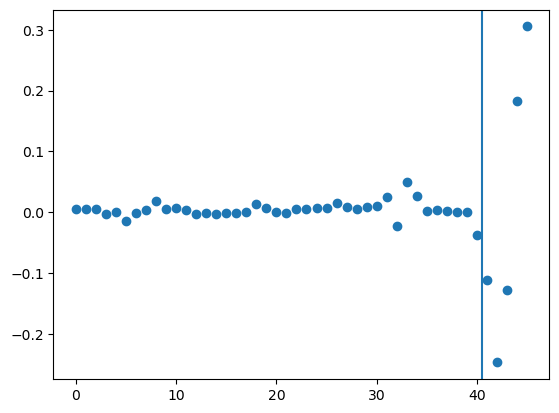

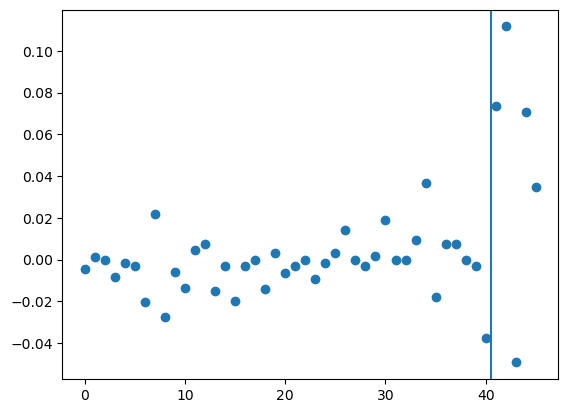

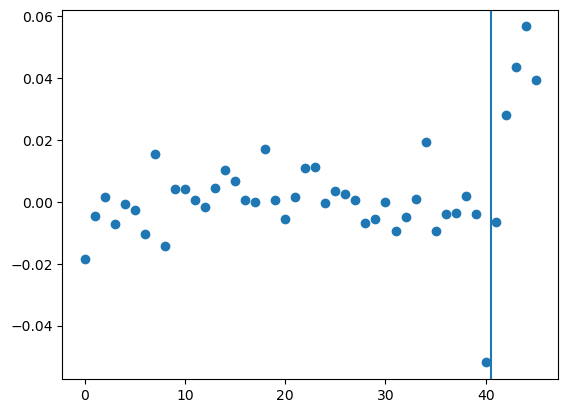

In [33]:
# printing out a few random predictions just to take a look at how the model did
x = set(train_data.cfips)
for i in range(3):
    cfip = random.sample(tuple(x),1)[0]
    plt.scatter(x=[x for x in range(0,46)], y=list(train_data[train_data.cfips == cfip].microbusiness_density))
    plt.axvline(x=40.5)
    plt.show()

In [34]:
# creating a df of all the predicted densities by county
res = pd.concat([pop_adj[["row_id", "microbusiness_density"]],train_data[train_data.t >= first_test_t][["row_id", "microbusiness_density"]]]).sort_values("row_id")
res["cfips"] = res["row_id"].map(lambda x: x.split("_")[0])
group = pd.DataFrame(res.groupby("cfips")["microbusiness_density"].agg(list))
group["microbusiness_list"] = group["microbusiness_density"]
group = group.drop("microbusiness_density", axis=1)
group.head(3)

,microbusiness_list
cfips,
10001,"[7.009183665212557, 7.06405566405158, -0.06777..."
10003,"[20.59898441928955, 22.155528103865414, 0.0828..."
10005,"[59.97743753592004, 58.1043065999213, -0.06821..."


In [35]:
# defining a small function that helps us transform percentage change into density
def mult(arr):
    x = 1
    for k in arr:
        x *= k+1
    return x

In [36]:
# using the mult function to produce results in the correct format
agg = res.merge(group, on="cfips")
agg["month"] = agg["row_id"].map(lambda x: int(x.split("-")[1]))
agg["t"] = agg["month"].map(lambda x: x-11 if x>7 else x+1)
agg["mult"] = agg.apply(lambda x: mult(x["microbusiness_list"][2:x["t"]+1]) if x["t"]>1 else 1, axis=1)
agg["microbusiness_density"] = agg.apply(lambda x: x["mult"]*(x["microbusiness_list"][1]) if x["t"]>1 else x["microbusiness_density"], axis=1)
result = agg[["row_id", "microbusiness_density"]]
# model results
result.head(3)

,row_id,microbusiness_density
0,10001_2022-11-01,7.009184
1,10001_2022-12-01,7.064056
2,10001_2023-01-01,6.585303


# Removing counties detrimental to our results

The final step before submitting the prediction was flagging counties where simply filling forward is likely to give better results than a predictive model.

The counties that were flagged include:
- counties where the model seemed to not be learning (the produced results were highly divergent from the actual data). This was pinpointed by finding counties with high sMAPE and with high difference between sMAPE calculated based on predicted values and sMAPE calculated based on forward filled values.
- very high standard deviation of density
- very high sum of month-to-month differences in density
- last value in the dataset has a z-score of above 2
- z-score for any of the predicted months of above 2

Some of the below code won't produce the expected results, as it was run in another notebook where predictions were run on three periods for which we had the actual data. The list of counties that will be dropped is provided below.

In [37]:
# the code finding counties where our model is struggling to learn

# defining a function that finds smape scores for the predicted data
def smape(actual, predicted):
    numerator = np.abs(actual - predicted)
    denominator = np.abs(actual) + np.abs(predicted)
    smape_val = (200 * np.mean(np.divide(numerator, denominator)))
    return smape_val

# creating a df containing the average smape value for each county
test = train_data[(train_data["t"] == target_t) | (train_data["t"] == target_t+1) | (train_data["t"] == target_t+2)].copy()
test["pred"] = y_pred
test["smape"] = test.apply(lambda row: smape(row["pred"], row["microbusiness_density"]), axis=1)
smapes = pd.DataFrame(test[["cfips", "smape"]].groupby("cfips")["smape"].agg(list))
smapes["mean"] = smapes.smape.map(lambda x: np.mean(x))
# finding a list of smapes with high mean values
high_smapes = list(smapes[(smapes["mean"] > 1.7)].index)

In [38]:
# the code finding counties where our model is struggling to learn

# adding a column of smape calculated based on forward filled values
last = train_data[train_data.t == 37][["cfips", "microbusiness_density"]]
last["last"] = last["microbusiness_density"]
last = last.drop("microbusiness_density", axis=1)
test = test.merge(last, on="cfips")
test["smape_ff"] = test.apply(lambda row: smape(row["last"], row["microbusiness_density"]), axis=1)
# adding a column with differences between smape from the model predictions and from forward filling
test["sdiff"] = test["smape"] - test["smape_ff"]
diffs = pd.DataFrame(test.groupby("cfips")["sdiff"].agg(sum))
# creating a list of counties where that difference is high
high_diff = list(diffs[diffs.sdiff > 0].index)

In [39]:
# the code finding counties with high standard deviation
std = {}
for elem in list(set(train["cfips"])):
    std[elem] = np.std(train[train["cfips"]==elem]["microbusiness_density"])/np.mean(train[train["cfips"]==elem]["microbusiness_density"])
pd.DataFrame(std, index=[1]).T.sort_values(by = 1)
std_list = list(pd.DataFrame(std, index=[1]).T.sort_values(by = 1).tail(400).index)

In [40]:
# the code finding counties with high total changes
movement_sum = {}
for elem in list(set(train["cfips"])):
    scaled_list = [x for x in train[train["cfips"]==elem]["microbusiness_density"]]
    to_sum = []
    for n in range(1, len(scaled_list)):
        to_sum.append(abs(scaled_list[n] - scaled_list[n-1]))
    movement_sum[elem] = sum(to_sum)/np.mean(train[train["cfips"]==elem]["microbusiness_density"])
distance_list = list(pd.DataFrame(movement_sum, index=[1]).T.sort_values(by = 1).tail(400).index)

In [41]:
# the code finding if the last data entry is an outlier
list_final_outl = []
for elem in list(set(train["cfips"])):
    z_value = list(abs(stats.zscore(train[train["cfips"] == elem]["microbusiness_density"])))[-1]
    if z_value > 2:
        list_final_outl.append(elem)

In [42]:
# the code finding if the any of the predicated data points is an outlier
list_pred_zscore = []
for elem in list(set(train["cfips"])):
    if max(abs(stats.zscore(list(train[train.cfips == elem].microbusiness_density))[-6:])) > 2:
        list_pred_zscore.append(elem)

In [43]:
# importing the pre-made list of counties to drop
with open("/kaggle/input/to-drop/to_drop", "rb") as fp:
    to_drop = pickle.load(fp)

In [44]:
# finding the last available value for each county and appending it to the results
result["cfips"] = result["row_id"].map(lambda x: int(x.split("_")[0]))
result["day"] = result["row_id"].map(lambda x: str(x.split("_")[1]))
last_available = result[result["day"] == "2022-12-01"][["cfips", "microbusiness_density"]].copy()
last_available["last"] = last_available["microbusiness_density"]
last_available = last_available.drop("microbusiness_density", axis=1)
new_result = result.merge(last_available, on="cfips")
new_result["year"] = new_result["row_id"].map(lambda x: x.split("_")[1].split("-")[0])
# forward filling the values for selected counties
new_result["microbusiness_density"] = new_result.apply(lambda x: x["last"] if ((x["year"] == "2023") and  (x["cfips"] in to_drop)) else x["microbusiness_density"], axis=1)
new_result = new_result[["row_id", "microbusiness_density", "cfips"]]

# Final Results

In [45]:
# final results, yay!
new_result.head(3)

,row_id,microbusiness_density,cfips
0,10001_2022-11-01,7.009184,10001
1,10001_2022-12-01,7.064056,10001
2,10001_2023-01-01,6.585303,10001


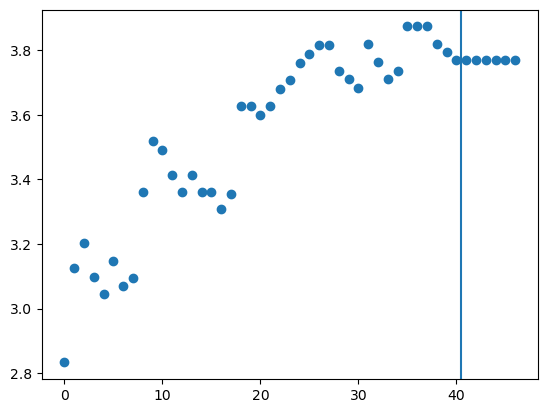

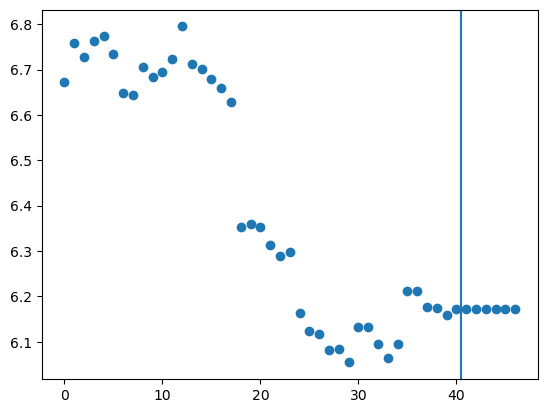

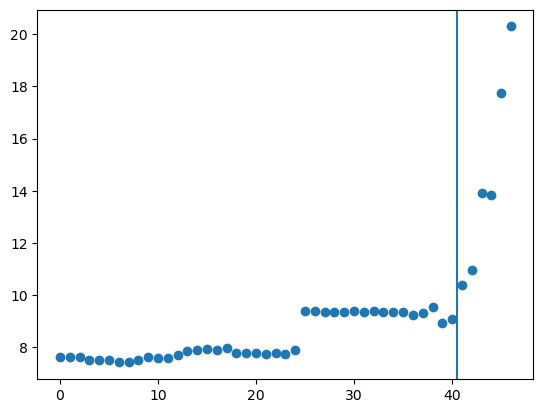

In [47]:
# putting together the predictions and the original data for the sake of visualization
for_visualization = pd.concat([pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv")[["row_id", "microbusiness_density", "cfips"]],new_result])
# printing out a few random results
x = set(train_data.cfips)
for i in range(3):
    cfip = random.sample(tuple(x),1)[0]
    plt.scatter(x=[x for x in range(0,47)], y=list(for_visualization[for_visualization.cfips == cfip].microbusiness_density))
    plt.axvline(x=40.5)
    plt.show()